# Tutorial 3a: Parameter estimation by optimziation

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t3a_parameter_estimation_by_optimization.ipynb).*

In [15]:
import numpy as np
import pandas as pd
import scipy.optimize
import statsmodels.tools.numdiff as smnd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

# We'll use Bokeh a bit
import bokeh.io
import bokeh.charts
bokeh.io.output_notebook()

Loading BokehJS ...

In this tutorial, we will extend our introduction to parameter estimation from lecture toward computing regressions on data.  We will start with a little theory to set up the problem, and then proceed to performing nonlinear regressions on real data.

## Introduction to Bayesian regression
Recall the problem of estimating a single parameter from repeated measurements from [lecture](../lecture_notes/l02_parameter_estimation.pdf).  We had a likelihood of

\begin{align}
P(D \mid \mu, \sigma, I) = \prod_{i\in d} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(x_i - \mu)^2}{2\sigma^2}\right].
\end{align}

In other words, we assumed our measurements were Gaussian distributed with some mean $\mu$ and a standard deviation $\sigma$.  We can think about this in terms of mathematical and statistical models.  Specifying the likelihood (and prior) is a *statistical model*, where we describe how the data are distributed.  The *mathematical model* is kind of trivial, so we didn't really pause to discuss it before.  Our mathematical model is that physical process underlying the data produces the same value $\mu$ of the data.  That is, the equation of our mathematical model is $x = \mu$.

The analysis we did is not limited to this special choice of mathematical.  For example, let's say we perform a measurement, getting result $y$ for a given value of $x$.  In this case, our data set would consist of $(x,y)$ pairs; $D = \{x_i, y_i\}$.  Say we derive a mathematical model such that $y = ax + b$.  If this is the case, we have a likelihood of

\begin{align}
P(D \mid a, b, \sigma, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(y_i - a x_i - b)^2}{2\sigma^2}\right],
\end{align}

where $\sigma$ is the unknown variance describing how the data deviate from the model.  This likelihood again assumes that the data vary off of the "ideal" given by the (linear) mathematical model in a Gaussian manner.

More generally, we could put any function in there.  Our mathematical model could be $y = f(x, \mathbf{a})$, where $\mathbf{a}$ is a set of parameters.  Then,

\begin{align}
P(D \mid \mathbf{a}, \sigma, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(y_i - f(x,\mathbf{a}))^2}{2\sigma^2}\right].
\end{align}

After specifying the prior, we have the posterior and are in principle done with our parameter estimation.  However, we do often want to summarize the posterior, and actually computing it for a general $f(x, \mathbf{a})$ can be intractable.  In this tutorial, we will work with a real data set and demonstrate some of the ways we describe the posterior without actually computing it fully.

## The data set

The data set we will use for this analysis comes from [Good, et al., Cytoplasmic volume modulates spindle size during embryogenesis
 *Science*, **342**, 856-860, 2013](../protected/papers/good_2013.pdf).  You can download the data set [here](../data/good_invitro_droplet_data.csv).  In this work, Matt Good and coworkers developed a microfluidic device where they could create droplets of cytoplasm extracted from *Xenopus* eggs and embryos (see image from the paper, below, with 20 µm scale bars).  A remarkable property about *Xenopus* extract is that mitotic spindles spontaneously form; the extracted cytoplasm has all the ingredients to form them.  This makes it an excellent model system for studying spindles.  With their device, Good and his colleagues were able to study how the size of the cell affects the dimensions of the mitotic spindle; a simple, yet beautiful, question.  The experiment is conceptually simple; they made the droplets and then measured their dimensions and the dimensions of the spindles using microscope images.  In this tutorial, we will analyze their data relating droplet size and spindle size.

![Droplets with spindles in them](good_droplets.png)

## Theoretical models for spindle size

Since we will be fitting the data with a theoretical model, I briefly summarize the two competing models for spindle size proposed by Good, et al. in their paper.

### Model a: Set spindle size

As a first model, we propose that the size of a mitotic spindle is inherent to the spindle itself.  This means that the size of the spindle is independent of the size of the droplet or cell in which it resides.  This would be the case, for example, if construction of the spindle involves length-sensing molecules, such as depolymerizing motor proteins (see, e.g., [this paper](../protected/papers/varga_2009.pdf) by Varga, et al.).  We define that set length as $\theta$.

This is the same problem as before: estimating the value of a parameter by repeated measurements.  The mathematical model in this case is $l = \theta$, where $l$ denotes the length of the spindle.  Each datum is then

\begin{align}
l_i = \theta + e_i,
\end{align}

where $e_i$ is the noise component of the $i$th datum.  The noise is assumed to come from a Gaussian distribution with variance $\sigma^2$.  The value of $\sigma$ is the same for all data.  In this case, the likelihood of a set of measurements $D = \{l_1, l_2,\ldots\}$ is

\begin{align}
P(D~|~\theta, \sigma, M_a, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(l_i - \theta)^2}{2\sigma^2}\right],
\end{align}

where $M_a$ denotes that Model a is true. 

### Model b: Spindle size is dependent on total tubulin concentration

This model hinges on the following principles:
1. The total amount of tubulin in the droplet or cell is conserved.
2. The total length of polymerized microtubules is a function of the total tubulin concentration after assembly of the spindle.  This results from the balances of microtubule polymerization rate with catastrophe frequencies.
3. The density of tubulin in the spindle is independent of droplet or cell volume.

From these principles, we'll proceed to derive a mathematical model to describe how spindle size should depend on droplet size.

Assumption 1 (conservation of tubulin) implies

\begin{align}
T_0 V_0 = T_1(V_0 - V_\mathrm{s}) + T_\mathrm{s}V_\mathrm{s},
\end{align}

where $V_0$ is the volume of the droplet or cell, $V_\mathrm{s}$ is the volume of the spindle, $T_0$ is the total tubulin concentration (polymerized or not), $T_1$ is the tubulin concentration in the cytoplasm after the the spindle has formed, and $T_\mathrm{s}$ is the concentration of tubulin in the spindle.  If we assume the spindle does not take up much of the total volume of the droplet or cell ($V_0 \gg V_\mathrm{s}$, which is the case as we will see when we look at the data), we have

\begin{align}
T_1 \approx T_0 - \frac{V_\mathrm{s}}{V_0}\,T_\mathrm{s}.
\end{align}

The amount of tubulin in the spindle can we written in terms of the total length of polymerized microtubules, $L_\mathrm{MT}$ as

\begin{align}
T_s V_\mathrm{s} = \alpha L_\mathrm{MT},
\end{align}

where $\alpha$ is the tubulin concentration per unit microtubule length.  (We will see that it is unimportant, but from the known geometry of microtubules, $\alpha \approx 2.7$ nmol/µm.)

We formalize assumption 2 into a mathematical expression.  Microtubule length should grow with increasing $T_1$.  There should also be a minimal threshold $T_\mathrm{min}$ where polymerization stops.  We therefore approximate the total microtubule length as a linear function,

\begin{align}
L_\mathrm{MT} \approx \left\{\begin{array}{ccl}
0 & &T_1 \le T_\mathrm{min} \\
\beta(T_1 - T_\mathrm{min}) & & T_1 > T_\mathrm{min}.
\end{array}\right.
\end{align}

Because spindles form in *Xenopus* extract, $T_0 > T_\mathrm{min}$, so there exists a $T_1$ with $T_\mathrm{min} < T_1 < T_0$, so going forward, we are assured that $T_1 > T_\mathrm{min}$.  Thus, we have

\begin{align}
V_\mathrm{s} \approx \alpha\beta\,\frac{T_1 - T_\mathrm{min}}{T_\mathrm{s}}.
\end{align}

With insertion of our expression for $T_1$, this becomes

\begin{align}
V_{\mathrm{s}} \approx \alpha \beta\left(\frac{T_0 - T_\mathrm{min}}{T_\mathrm{s}} - \frac{V_\mathrm{s}}{V_0}\right).
\end{align}

Solving for $V_\mathrm{s}$, we have

\begin{align}
V_\mathrm{s} \approx \frac{\alpha\beta}{1 + \alpha\beta/V_0}\,\frac{T_0 - T_\mathrm{min}}{T_\mathrm{s}}
=\frac{V_0}{1 + V_0/\alpha\beta}\,\frac{T_0 - T_\mathrm{min}}{T_\mathrm{s}}.
\end{align}

We approximate the shape of the spindle as a prolate spheroid with major axis length $l$ and minor axis length $w$, giving

\begin{align}
V_\mathrm{s} = \frac{\pi}{6}\,l w^2 = \frac{\pi}{6}\,k^2 l^3,
\end{align}

where $k \equiv w/l$ is the aspect ratio of the spindle.  We can now write an expression for the spindle length as

\begin{align}
l \approx \left(\frac{6}{\pi k^2}\,
\frac{T_0 - T_\mathrm{min}}{T_\mathrm{s}}\,
\frac{V_0}{1+V_0/\alpha\beta}\right)^{\frac{1}{3}}.
\end{align}

For small droplets, with $V_0\ll \alpha \beta$, this becomes

\begin{align}
l(d) \approx \left(\frac{6}{\pi k^2}\,
\frac{T_0 - T_\mathrm{min}}{T_\mathrm{s}}\,
V_0\right)^{\frac{1}{3}}
= \left(\frac{T_0 - T_\mathrm{min}}{k^2T_\mathrm{s}}\right)^{\frac{1}{3}}\,d,
\end{align}

where $d$ is the diameter of the spherical droplet or cell. So, we expect the spindle size to increase linearly with the droplet diameter for small droplets.  

For large $V_0$, the spindle size becomes independent of droplet size;

\begin{align}
l \approx \left(\frac{6 \alpha \beta}{\pi k^2}\,
\frac{T_0 - T_\mathrm{min}}{T_\mathrm{s}}\right)^{\frac{1}{3}}.
\end{align}

We can define two parameters to describe the data,

\begin{align}
\gamma &= \left(\frac{T_0-T_\mathrm{min}}{k^2T_\mathrm{s}}\right)^\frac{1}{3} \\
\theta &= \gamma\left(\frac{6\alpha\beta}{\pi}\right)^{\frac{1}{3}}.
\end{align}

We assume that $\gamma$ and $\theta$ are the same for all data.  We can rewrite the general model expression in terms of these parameters as

\begin{align}
l(d) \approx \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

For small and large droplets, respectively, we have

\begin{align}
l(d) &\approx \gamma d ~\text{ for } \gamma d/\theta \ll 1, \\[1em]
l &\approx \theta ~~~\text{ for } \gamma d/\theta \gg 1.
\end{align}

Note that the expression for the linear regime gives bounds for $\gamma$.  Obviously, $\gamma > 0$.  Because $l \le d$, lest the spindle not fit in the droplet, we also have $\gamma \le 1$.  The parameter $\theta$ is independent of the system geometry, so it only has the physical lower bound of $\theta > 0$.

To get an idea of what we might expect from the shapes of curves from these two models, let's make some plots.  This is easiest if we choose $\theta$ as the units for both the $x$- and $y$-axes.

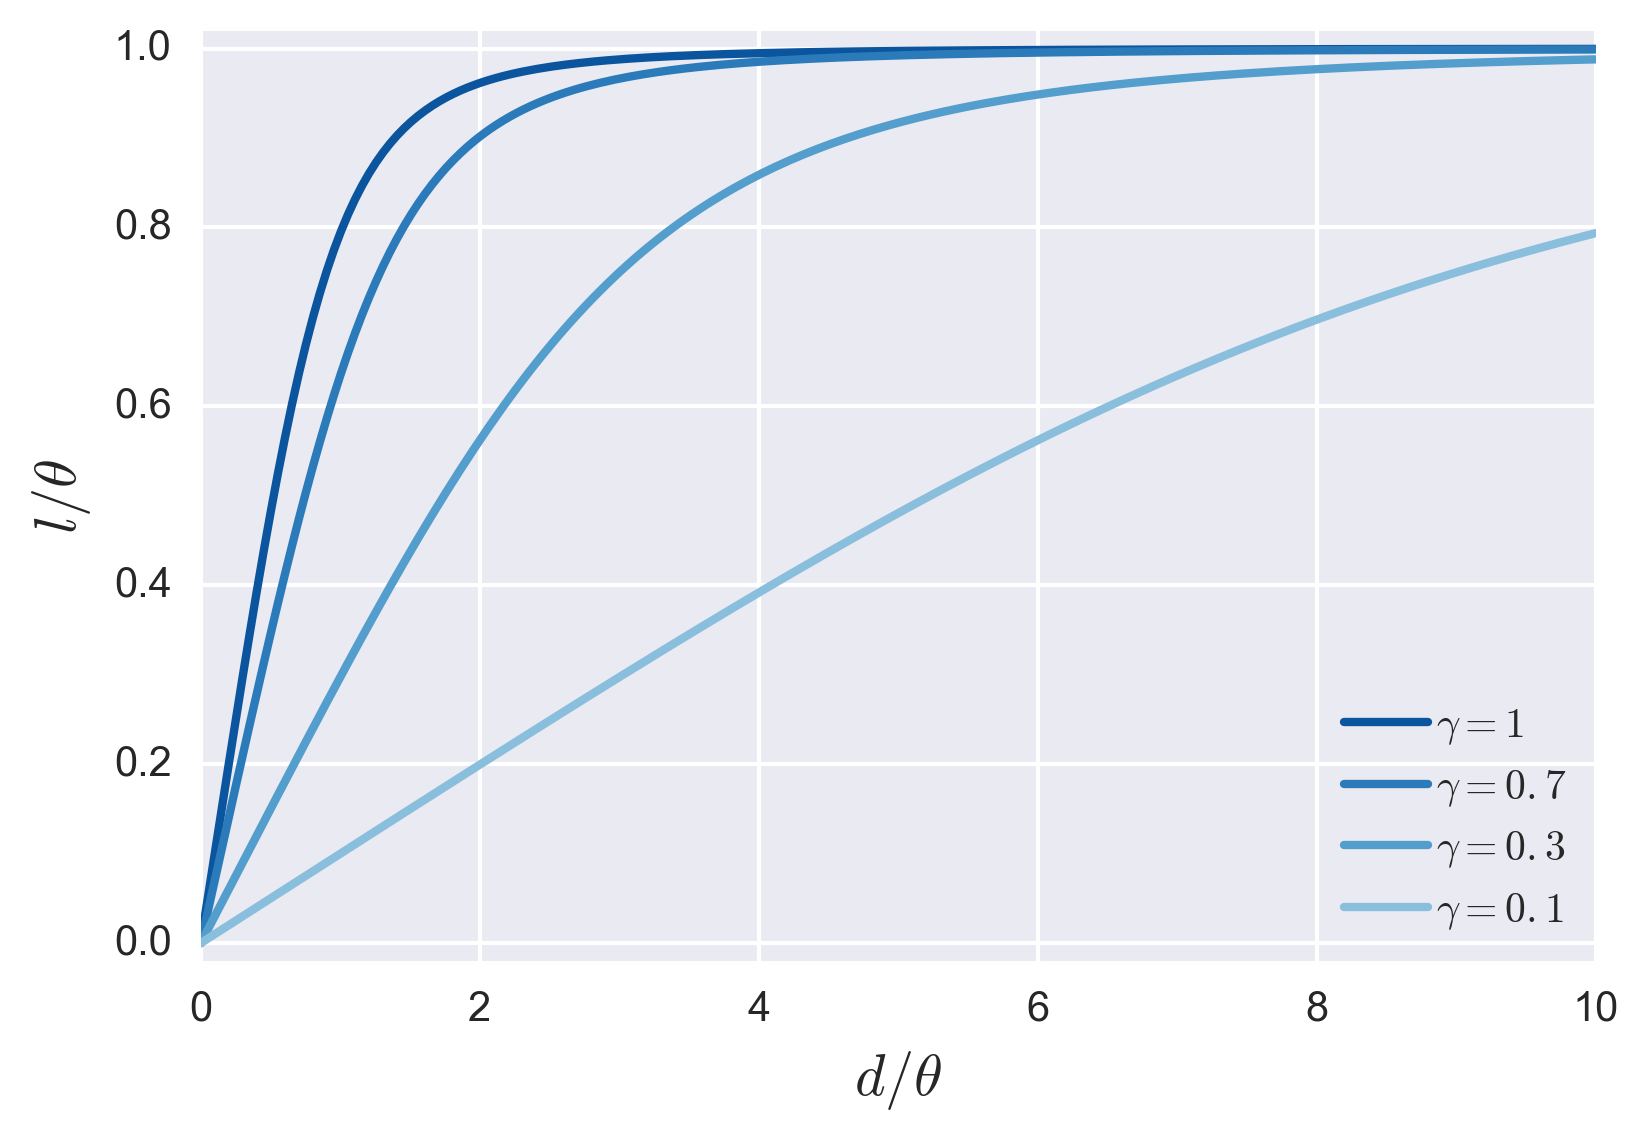

In [16]:
# Generate dimensionless d range to plot
d = np.linspace(0.0, 10.0, 200)

# Values of gamma to use in the plot
gamma = np.array([0.1, 0.3, 0.7, 1.0])

# Make the plots
with sns.color_palette('Blues_r'):
    legend_labels = []
    for i in range(len(gamma)-1, -1, -1):
        plt.plot(d, gamma[i] * d / (1 + (gamma[i] * d)**3)**(1.0 / 3.0), '-')
        legend_labels.append(r'$\gamma = {0:g}$'.format(gamma[i]))

# Make plot pretty
plt.margins(y=0.02)
plt.xlabel(r'$d/\theta$')
plt.ylabel(r'$l/\theta$')
plt.legend(legend_labels, loc='lower right');

We can also look at how the different limits compare to the theoretical curves.  We will do this for $\gamma = 0.3$, plotting the limits as dashed lines.

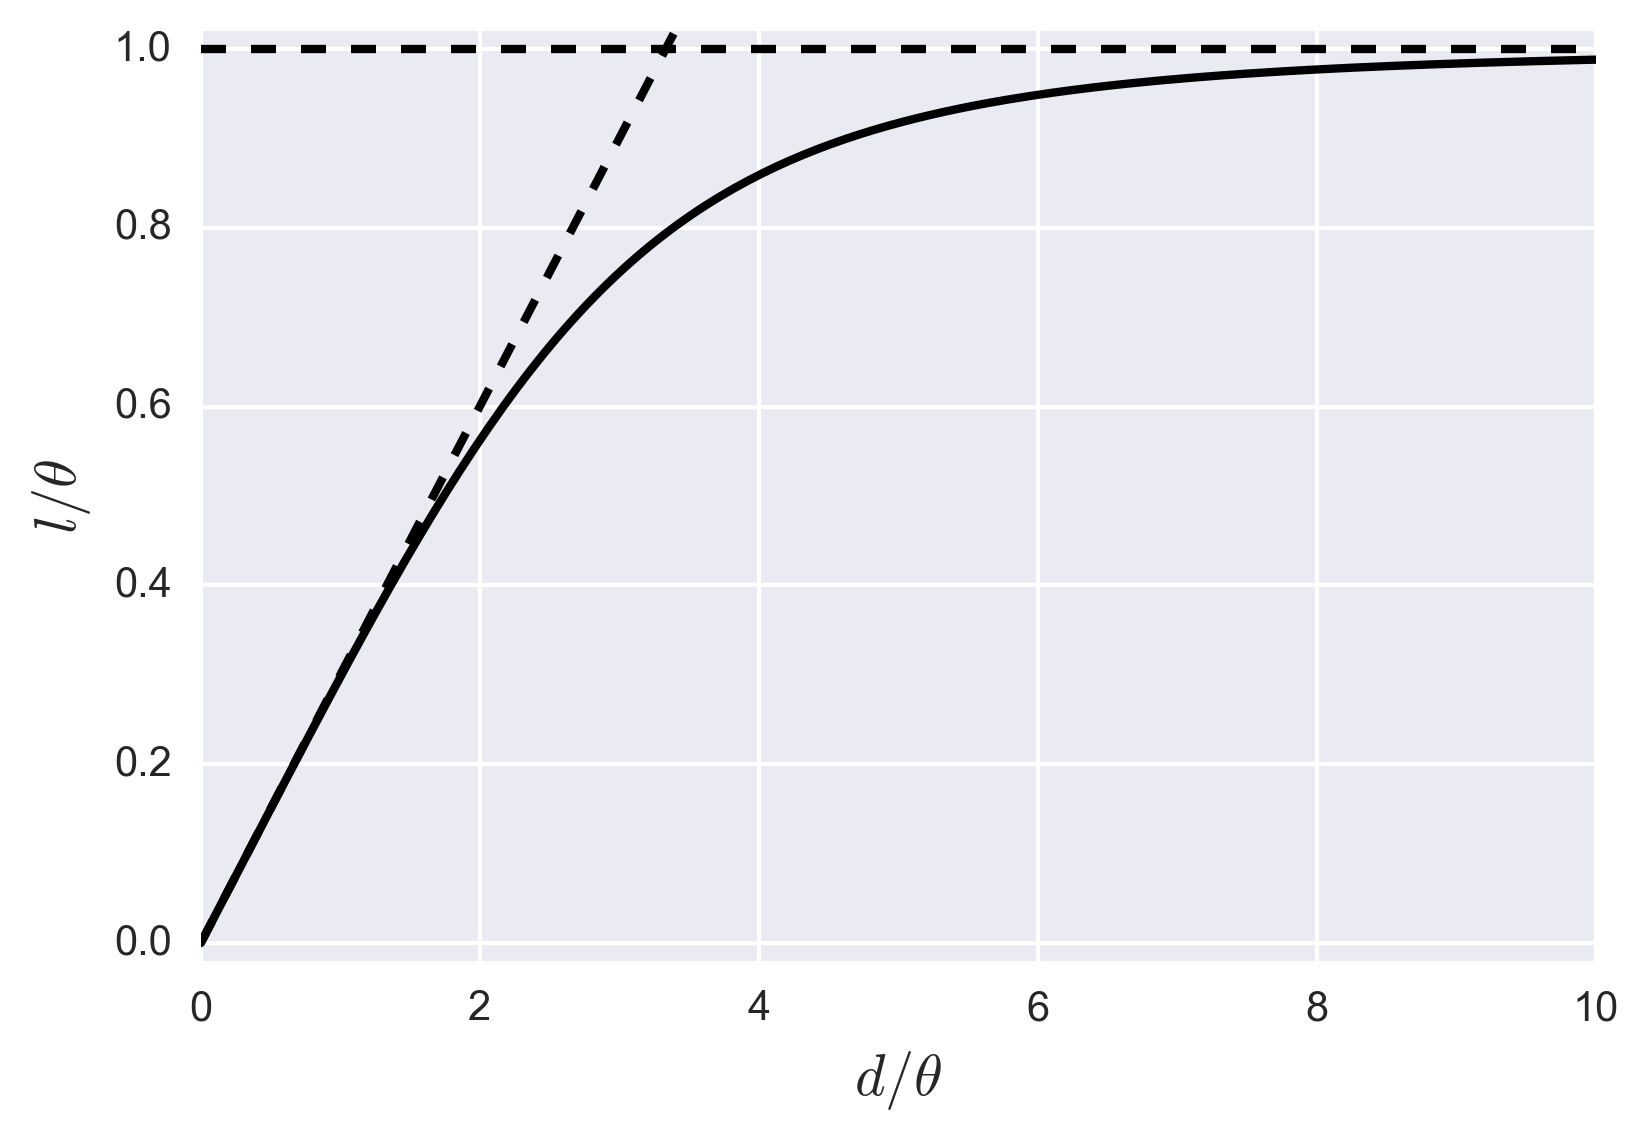

In [17]:
# Plot the full theoretical curve for gamma = 0.3
gamma = 0.3
plt.plot(d, gamma * (d**3 / (1 + (gamma * d)**3))**(1.0 / 3.0), 'k-')

# Plot plateau region (horizontal line at y = 1)
plt.plot([d[0], d[-1]], [1.0, 1.0], 'k--')

# Plot linear region
plt.plot([d[0], d[-1]], gamma * np.array([d[0], d[-1]]), 'k--')

# Make plot pretty
plt.ylim((-0.02, 1.02))
plt.xlabel(r'$d/\theta$')
plt.ylabel(r'$l/\theta$');

We can now write the likelihood under this model.

\begin{align}
P(D \mid \theta, \gamma, M_b, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(l_i - l(d_i;\theta, \gamma))^2}{2\sigma^2}\right],
\end{align}

where

\begin{align}
l(d; \theta, \gamma) = \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

### A comment on the model parameters

We went through some algebraic manipulations to get our mathematical model in a form with two parameters.  We want to try to identify *independent* parameters in your mathematical before doing regression analysis.  In a trivial example, imagine someone proposed the following model to use in a regression on $(x, y)$ data:

\begin{align}
y = ax + bx + c.
\end{align}

Obviously, it would be silly to have both $a$ and $b$ as regression parameters, and we should instead define a new parameter $d = a + b$ and use that as a regression parameter.  In the case of spindle length, we had parameters $T_0$, $T_\mathrm{min}$, $T_\mathrm{s}$, $k$, $\alpha$, and $\beta$, but, as we saw, we can only resolve two parameters, $\gamma$ and $\theta$.  Furthermore, if we happen to be in the linear regime, $\theta$ does not enter the expressions, so we obviously cannot resolve it.  Similarly, we can only determine $\theta$ if we are in the plateau regime.

Finally, we note that if the parameters are such that we are in the plateau regime, we cannot discern Model a from Model b.  This tells us that as experimenters, we need to study a range of droplet sizes so we can cover both regimes.

## Loading the data

Matt Good sent me beautifully organized and formatted (tidy!) data files (you should have  something similar available for all of your publications!).  We will load in the data used to generate Fig. 1C of the paper.

In [18]:
# Load data into DataFrame
df = pd.read_csv('../data/good_invitro_droplet_data.csv', comment='#')

# Check it out
df.head()

,Droplet Diameter (um),Droplet Volume (uL),Spindle Length (um),Spindle Width (um),Spindle Area (um2)
0,27.1,0.000010,28.9,10.8,155.8
1,28.2,0.000012,22.7,7.2,81.5
2,29.4,0.000013,26.2,10.5,138.3
3,31.0,0.000016,19.2,9.4,90.5
4,31.0,0.000016,28.4,12.1,172.4


Conveniently, the data are tidy, and we're ready to go!

## Checking the model 2 assumptions

As an aside, it is often useful to check the assumptions associated with the model we chose.  Remember, we assumed that the volume of the spindle was much less than the volume of the droplet ($V_\mathrm{s} / V_0 \ll 1$) and that the aspect ratio of the spindle, $k$, is the same for all spindles.

### Is $V_\mathrm{s} / V_0 \ll 1$?

Let's do a quick verification that the droplet volume is indeed much larger than the spindle volume.  Remember, the spindle volume for a prolate spheroid of length $l$ and width $w$ is $V_\mathrm{s} = \pi l w^2 / 6$.  Also remember that 1 µL = $10^{-9}$ µm$^3$.

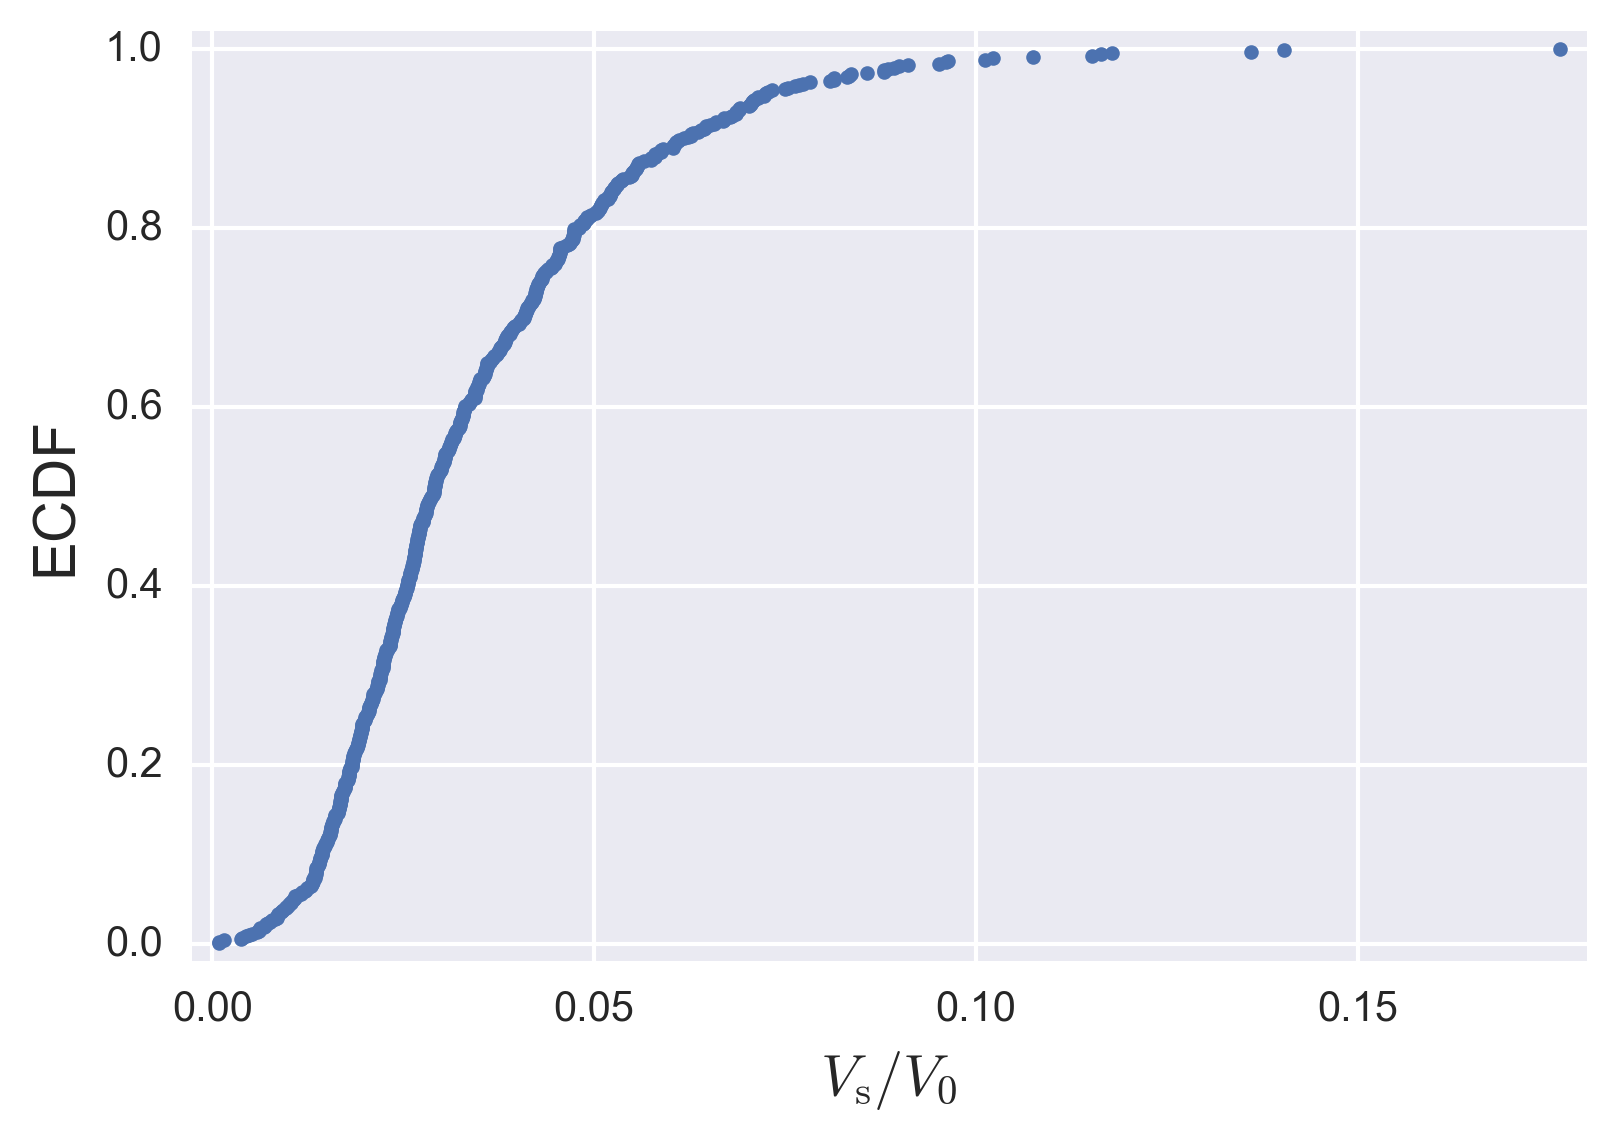

In [19]:
# Compute spindle volume
spindle_volume = np.pi * df['Spindle Length (um)'] \
                        * df['Spindle Width (um)']**2 / 6.0 * 1e-9

# Compute the ratio V_s / V_0
vol_ratio = spindle_volume / df['Droplet Volume (uL)']

# Compute ECDF of the results
ecdf = lambda x: (np.sort(x), np.arange(1, len(x)+1) / len(x))
x, y = ecdf(vol_ratio)

# Plot the ECDF
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel(r'$V_\mathrm{s} / V_0$')
plt.ylabel('ECDF');

We see that for the vast majority of spindles that were measured, $V_\mathrm{s} / V_0$ is small.

### Do all spindles have the same aspect ratio $k$?

In setting up our model, we assumed that all spindles had the same aspect ratio.  We can check this assumption because we have the data to do so available to us.

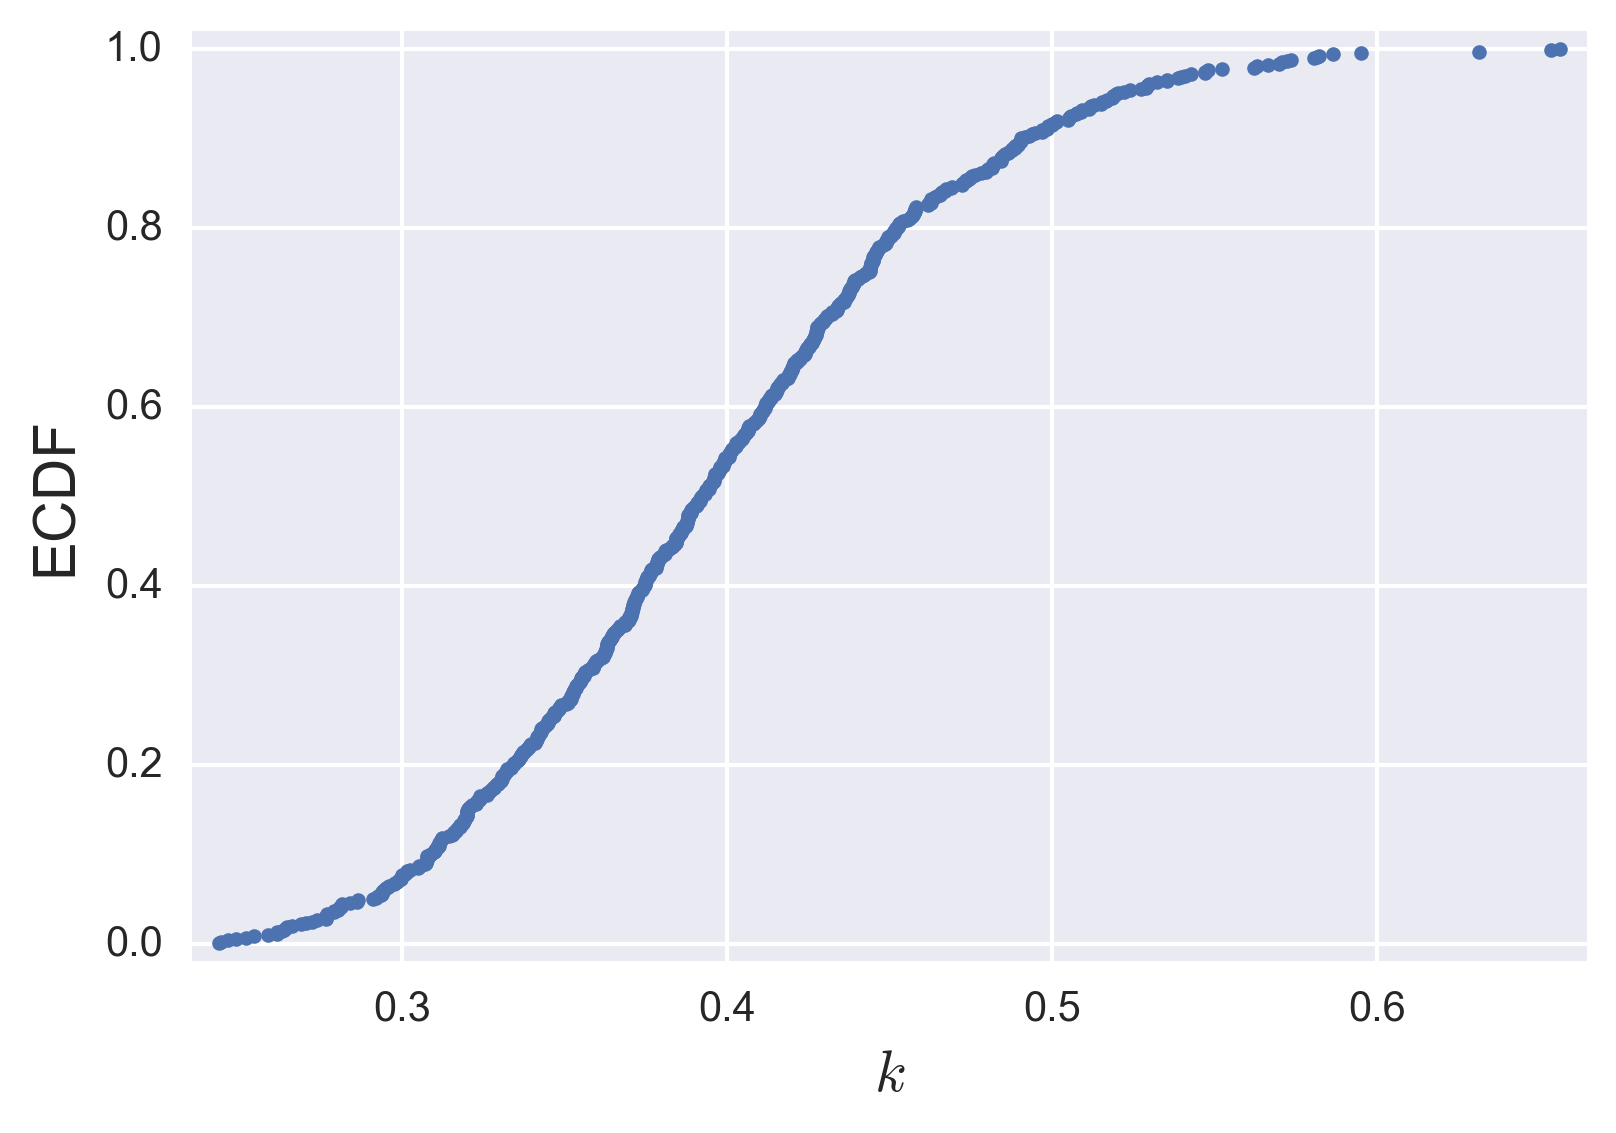

In [20]:
# Compute the aspect ratio
k = df['Spindle Width (um)'] / df['Spindle Length (um)']

# Plot an ECDF of aspect ratio
x, y= ecdf(k)
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel(r'$k$')
plt.ylabel('ECDF');

The mean aspect ratio is about 0.4, and we see spindle lengths about $\pm 25\%$ of that.  This could be significant variation, but we will leave it to the homework to test that.  For the purposes of this tutorial, we will assume that $k$ is constant.

## Exploratory data analysis

As we have mentioned before in class, it is often useful to explore the data by plotting it ahead of more formal analysis.  So, to start, we will plot the data generating a plot similar to Fig. 1C in the paper.  We plot spindle length vs. droplet diameter.

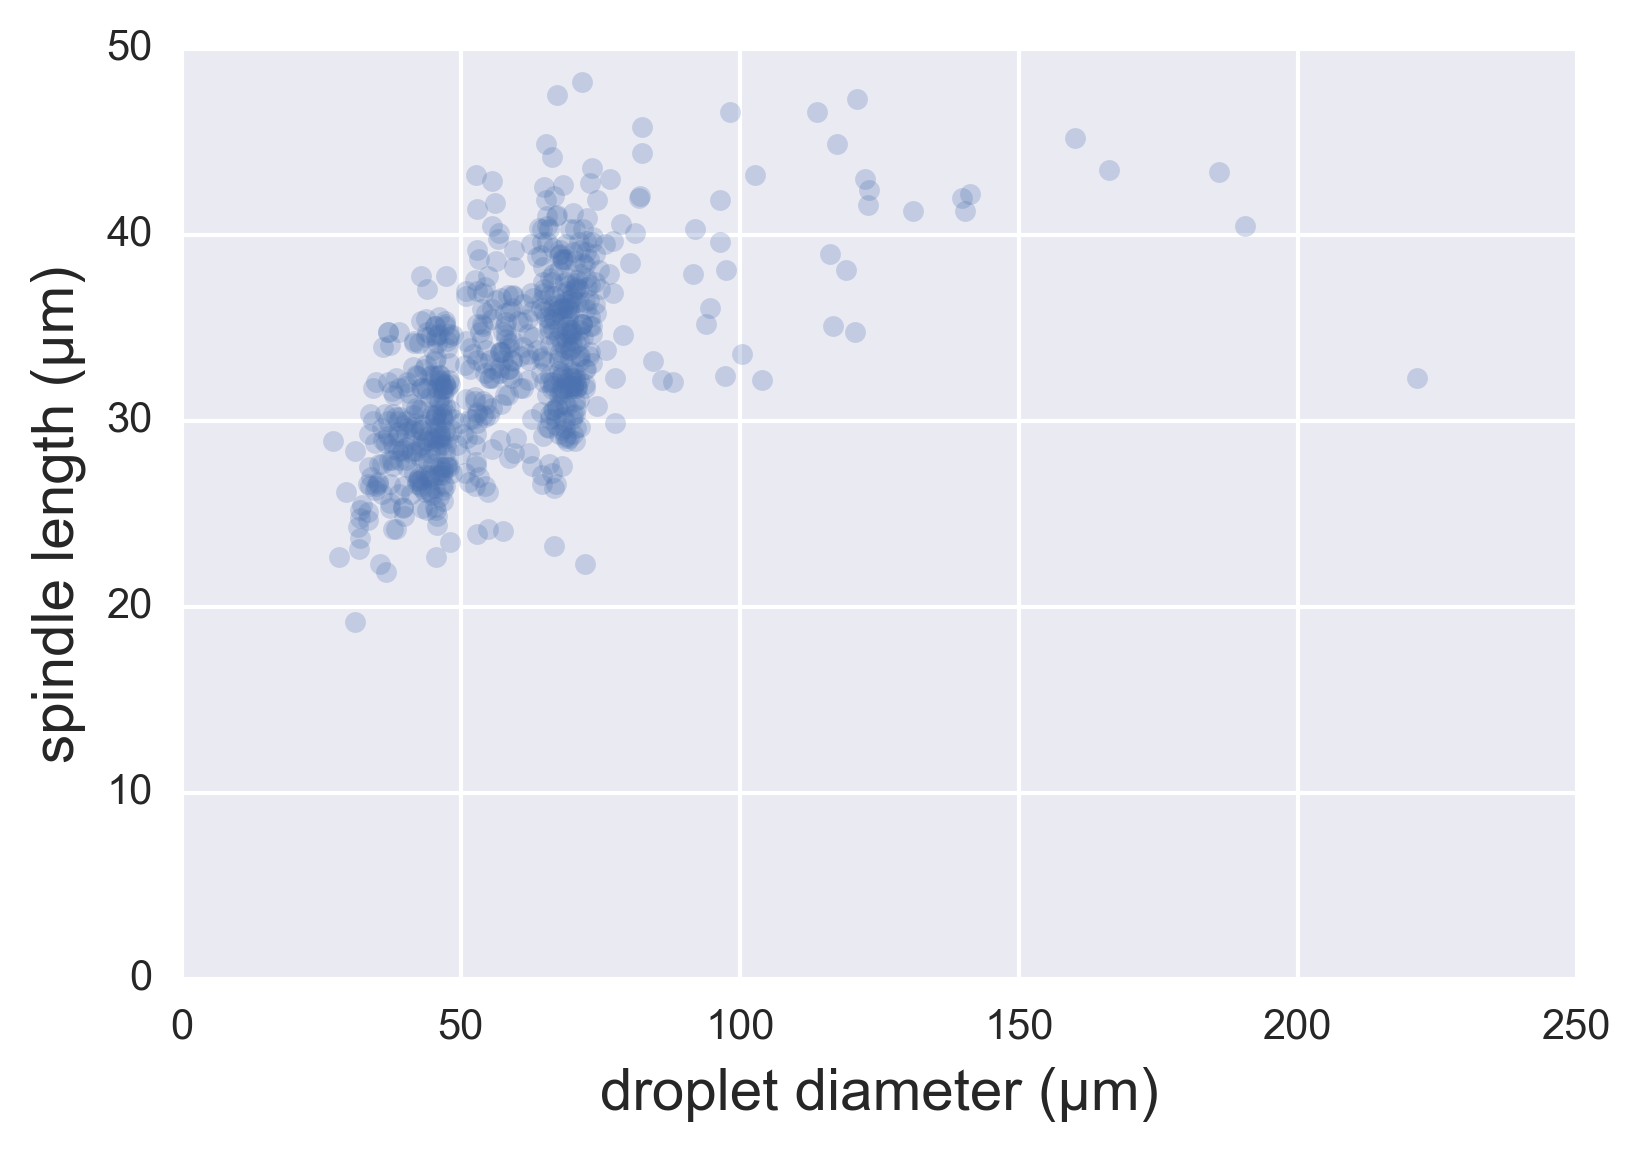

In [21]:
# Use alpha when you have lots of points; helps see overlap
plt.plot(df['Droplet Diameter (um)'], df['Spindle Length (um)'], marker='.', 
         linestyle='none', markersize=10, alpha=0.25)
plt.ylim(0.0, 50.0) # Be sure to include origin
plt.xlabel('droplet diameter (µm)')
plt.ylabel('spindle length (µm)');

Of course, for quick, exploratory data analysis, Bokeh is even better.

In [22]:
# Use alpha when you have lots of points; helps see overlap
p = bokeh.charts.Scatter(df, x='Droplet Diameter (um)', y='Spindle Length (um)',
                         height=350, width=600, color='dodgerblue')
bokeh.io.show(p)

## Parameter estimation under Model a

In Model a, we assume that spindle length is independent of the droplet diameter and that each measurement has the same Gaussian distribution for its error.  We have already worked out how to perform the estimate for the spindle length, $\theta$, in lecture.  The posterior is given by the Student-t distribution.

\begin{align}
P(\theta \mid D, M_a, I) = \frac{\Gamma\left(\frac{n}{2}\right)}{\sqrt{\pi}\,\Gamma\left(\frac{n-1}{2}\right)}\,\frac{1}{r}\left(1 + \frac{\left(\theta - \bar{l}\right)^2}{r^2}\right)^{-\frac{n}{2}},
\end{align}

where $n = |D|$, and 

\begin{align}
\bar{l} &= \frac{1}{n}\sum_{i\in D} l_i,\\[1em] 
\text{and } r^2 &= \frac{1}{n}\sum_{i\in D} (l_i - \bar{l})^2.
\end{align}

Clearly, the most probable value of $\theta$ is $\bar{l}$.  To compute its error bar, we will employ a trick we will use more generally in regression.  We will approximate the posterior distribution as Gaussian at its maximum and then report an error bar based on the variance of that Gaussian.  To make the Gaussian approximation, we expand the logarithm of the posterior in a Taylor series to second order.

\begin{align}
\ln P(\theta \mid D, M_a, I) = \text{constant} - \frac{n}{2}\,\ln\left(1 + \frac{(\theta - \bar{l})^2}{r^2}\right)
\approx \text{constant} - \frac{n(\theta - \bar{l})^2}{r^2}.
\end{align}

Exponentiating this expression, we get that

\begin{align}
P(\theta \mid D, M_a, I) \approx \frac{1}{\sqrt{2\pi r^2 / n}}\,
\exp\left[-\frac{(\theta - \bar{l})^2}{2 r^2 / n}\right].
\end{align}

Thus, $\theta$ is Gaussian distributed with a variance of $r^2/n$.  We could then report an error bar, which contains approximately 68% of the probability, as

\begin{align}
\theta = \bar{l} \pm\left.r\middle/\sqrt{n}\right..
\end{align}

This error bar of $\left.r\middle/\sqrt{n}\right.$ is often called the **standard error of the mean**, as it represents the error in an estimate of a mean.  Now that we know how to do this, we can directly compute our estimate using Numpy functions

In [23]:
# Estimate spindle length for Model a
theta = np.mean(df['Spindle Length (um)'])
r = np.std(df['Spindle Length (um)'])
n = len(df['Spindle Length (um)'])

# Print results
print("""
Model a results (≈68% of total posterior probability)
-----------------------------------------------------
θ = {0:.1f} ± {1:.1f} µm
""".format(theta, r / np.sqrt(n)))


Model a results (≈68% of total posterior probability)
-----------------------------------------------------
θ = 32.9 ± 0.2 µm



Note that we have a very good estimate of the mean; the error bar is small compared to the value.  This is often the case when there is a large number of measurements.  We know the mean very well; but error of the mean does not directly tell us about spread in the data.

Let's plot the model prediction with the data.

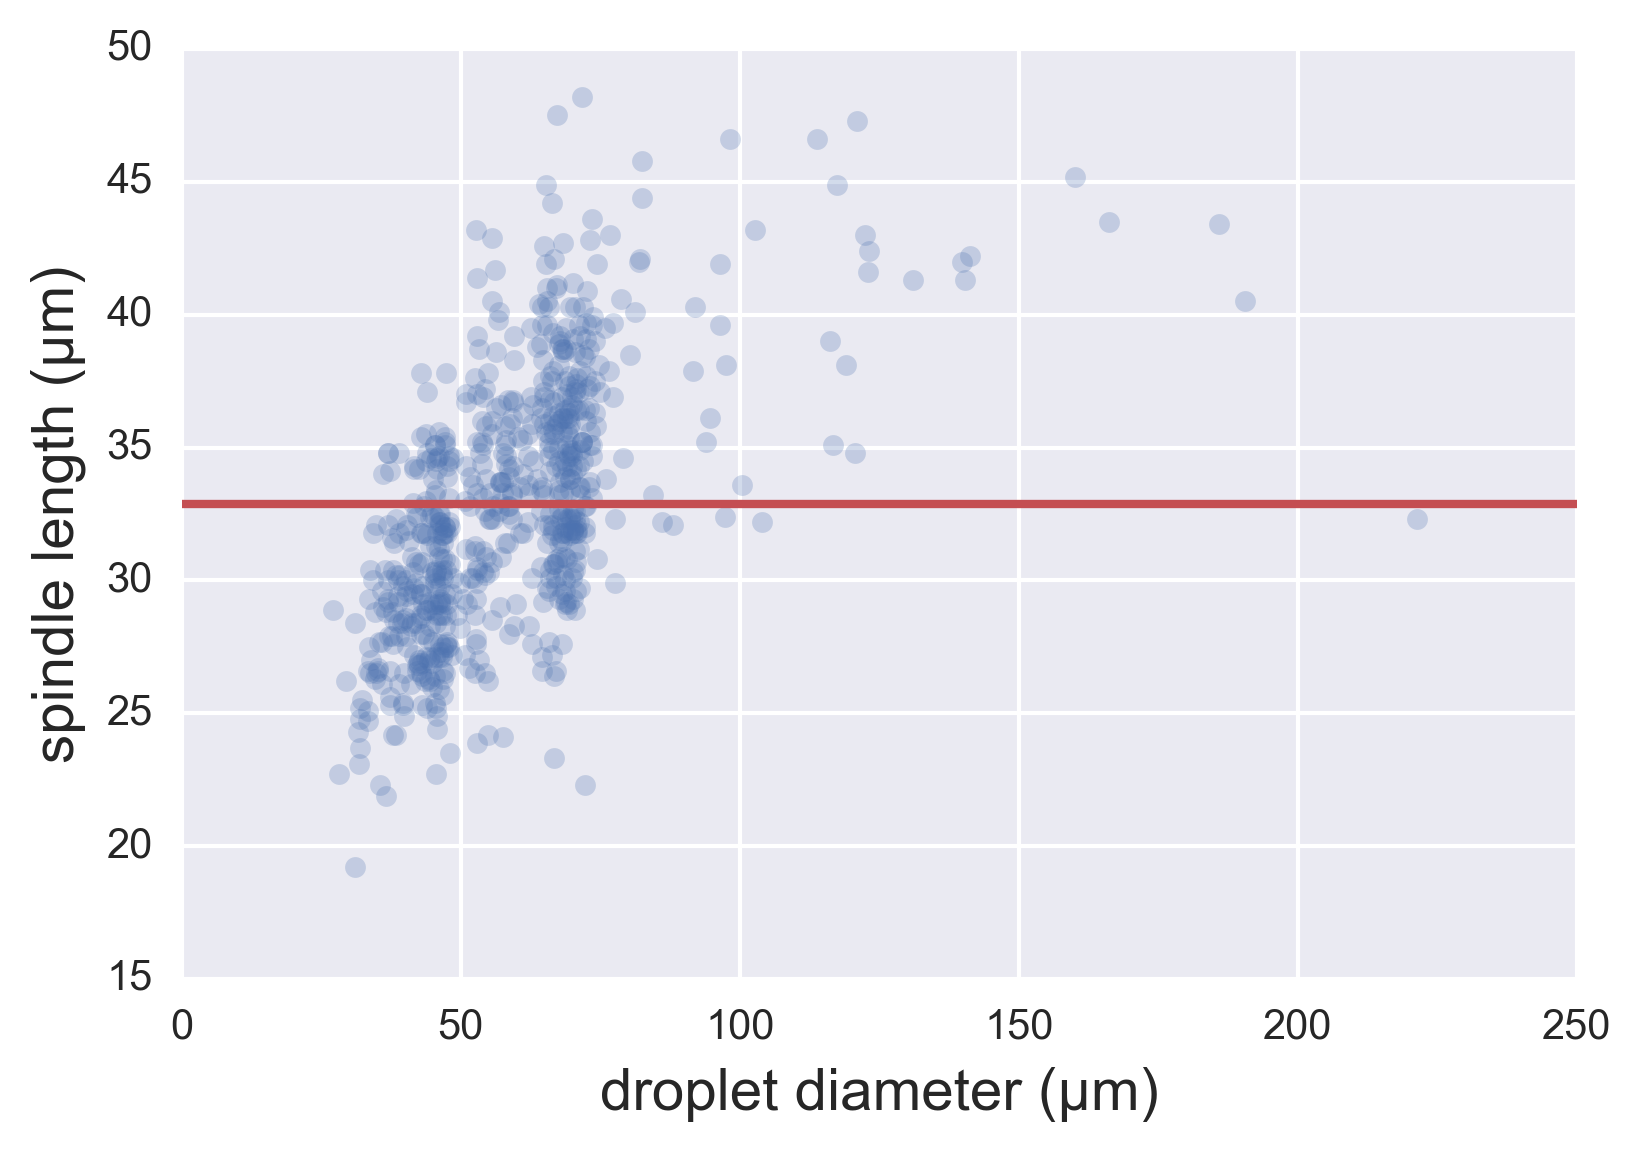

In [24]:
# Use alpha when you have lots of points; helps see overlap
plt.plot(df['Droplet Diameter (um)'], df['Spindle Length (um)'], marker='.', 
         linestyle='none', markersize=10, alpha=0.25)

# Plot the result
plt.plot([0, 250], [theta, theta], color=sns.color_palette()[2])
plt.xlabel('droplet diameter (µm)')
plt.ylabel('spindle length (µm)');

## Parameter estimation for Model b (nonlinear regression)
Nonlinear regression is just a fancy name for a certain kind of parameter estimation.  We will do the parameter estimation as we laid out at the beginning.  We already computed the likelihood.  We have three parameters, the two which came from the mathematical model, $\theta$ and $\gamma$, plus the unknown variance in the data, given by $\sigma$.  We assume uniform priors for $\theta$ and $\gamma$ and a Jeffreys prior for $\sigma$.  The posterior is then

\begin{align}
P(\theta, \gamma, \sigma \mid D, I) \propto\frac{1}{\sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D}(l_i - l(d_i;\theta, \gamma))^2\right],
\end{align}

where

\begin{align}
l(d; \theta, \gamma) = \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

We can marginalize the posterior over $\sigma$ exactly as before, giving a Student-t distribution.

\begin{align}
P(\theta, \gamma \mid D, I) \propto \left(\sum_{i\in D}(l_i - l(d_i;\theta, \gamma))^2\right)^{-\frac{n}{2}} .
\end{align}

Note that this marginalization is independent of the choice of the functional form of $l(d;\theta, \gamma)$, and is therefore valid for any regression where the errors are Gaussian distributed.  With the posterior in hand, we can plot it.  We don't really care about the normalization, since we just want a plot and can always numerically normalize it.

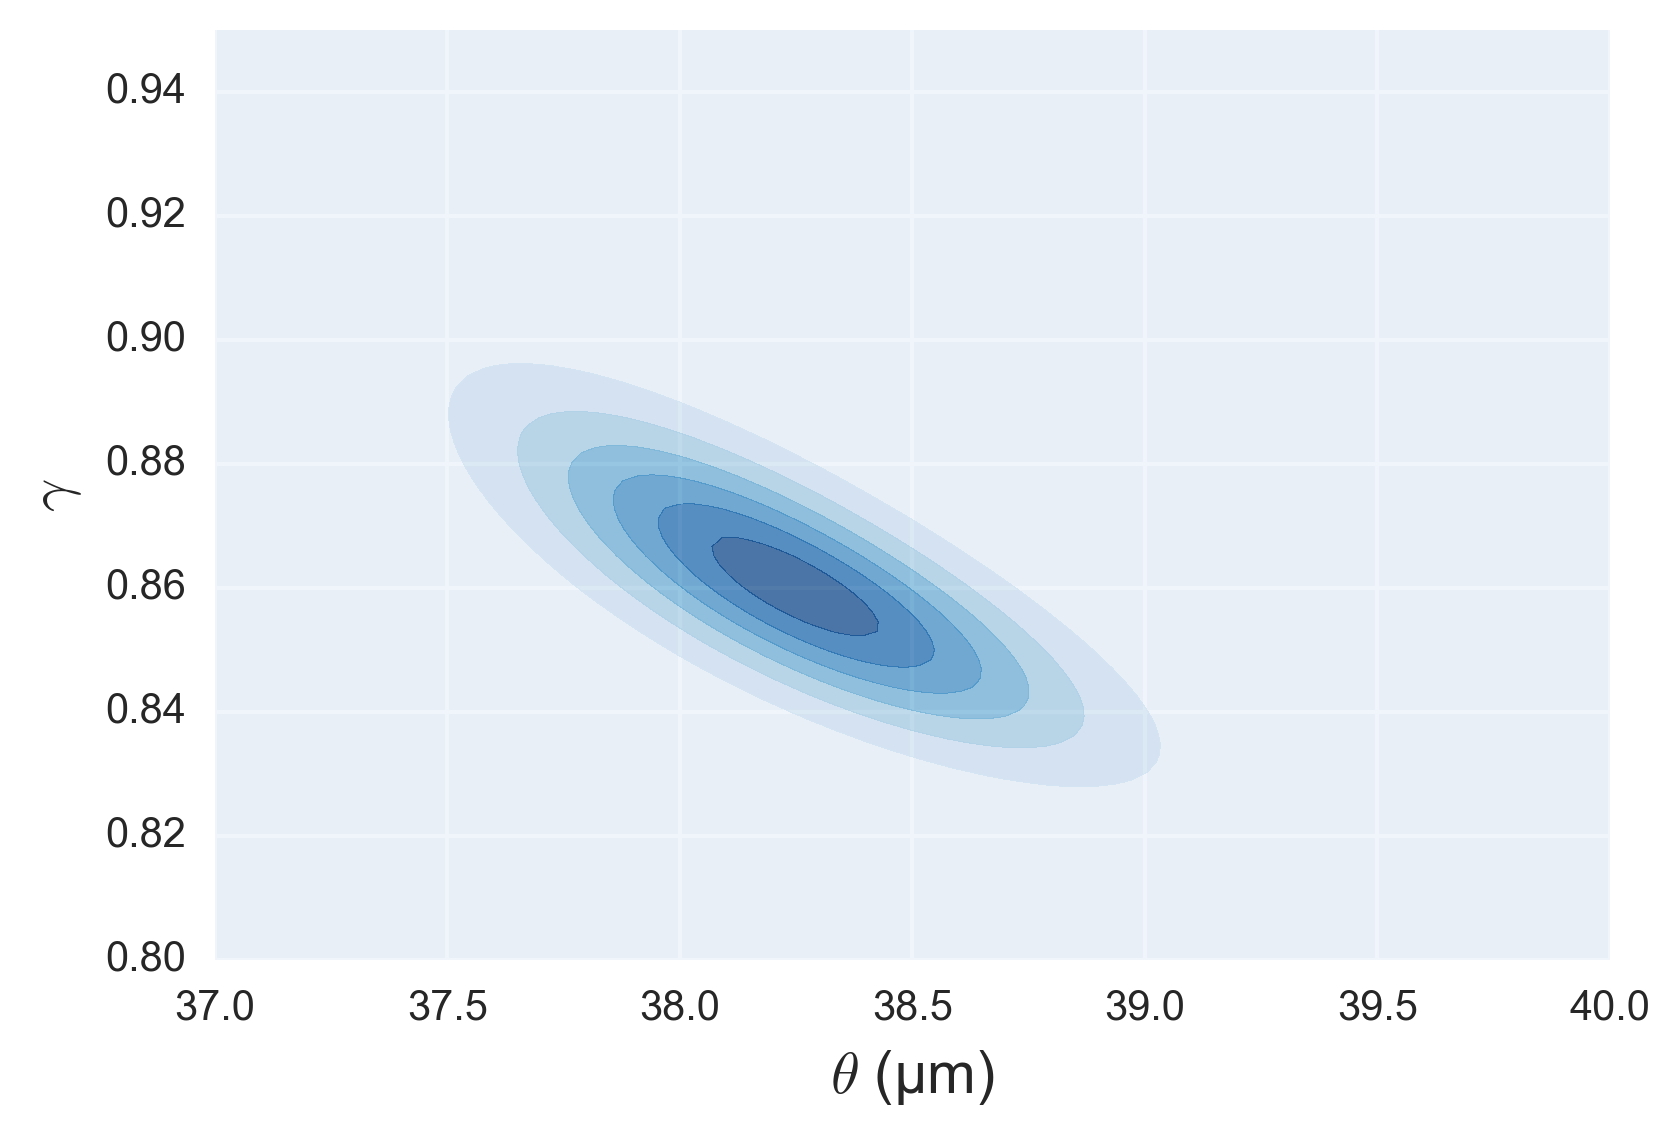

In [25]:
def spindle_length(p, d):
    """
    Theoretical model for spindle length
    """
    theta, gamma = p
    return gamma * d / np.cbrt(1 + (gamma * d / theta)**3)

def log_post(p, d, ell):
    """
    Compute log of posterior for single set of parameters.
    p[0] = theta
    p[1] = gamma
    """
    # Unpack parameters
    theta, gamma = p
    
    # Theoretical spindle length
    ell_theor = spindle_length(p, d)
    
    return -len(d) / 2 * np.log(np.sum((ell - ell_theor)**2))

# Parameter values to plot
th = np.linspace(37, 40, 100)
gamma = np.linspace(0.8, 0.95, 100)

# Make a grid
tt, gg = np.meshgrid(th, gamma)

# Compute log posterior
log_posterior = np.empty_like(tt)
for j in range(len(th)):
    for i in range(len(gamma)):
        log_posterior[i, j] = log_post(np.array([tt[i,j], gg[i,j]]),
                                       df['Droplet Diameter (um)'],
                                       df['Spindle Length (um)'])

# Get things to scale better
log_posterior -= log_posterior.max()
        
# Plot the results
plt.contourf(tt, gg, np.exp(log_posterior), cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$\theta$ (µm)')
plt.ylabel(r'$\gamma$');

Again, in principle, we are finished with parameter estimation for this model.  The posterior tells us all we could ask for.  In this case, we see that the most probable value of $\theta$ is about 38.25 µm, and the most probable $\gamma$ is about 0.86.  They are also negatively correlated; a larger $\theta$ results in a smaller $\gamma$.

### Gaussian approximation of the posterior

However, we often want to report summaries of the posterior, so we will take the same approach as in Model a and approximate it as a Gaussian.  We will do the same procedure: expand the logarithm of the posterior in a Taylor series to give a two-dimensional Gaussian.  In general, for a set of parameters $\mathbf{a}$, where $\mathbf{a}^*$ is the most probable values, the approximation to give a Gaussian is

\begin{align}
\ln P(\mathbf{a}\mid D, I) \approx \text{constant} + \frac{1}{2}\left(\mathbf{a} - \mathbf{a}^*\right)^T \cdot \mathsf{H} \cdot \left(\mathbf{a} - \mathbf{a}^*\right),
\end{align}

where $\mathsf{H}$ is the symmetric **Hessian matrix** of second derivatives,

\begin{align}
H_{ij} = \left.\frac{\partial^2\,\ln P(\mathbf{a}\mid D, I)}{\partial a_i\,\partial a_j}\right|_{\mathbf{a} = \mathbf{a}^*}.\\[0.1em]
\phantom{blah}
\end{align}

Because we are evaluating the second derivatives at the maximal posterior probability, the Hessian is positive definite and therefore invertible.  Its negative inverse is the **covariance matrix**, $\sigma^2$.

So, our task is two-fold.  First, find the parameter values that give the maximal posterior probability, the so-called **maximal a posteriori estimate**, or MAP.  Second, compute the Hessian of the log posterior at the MAP and invert it to get your covariance matrix.  Note that the covariance matrix is **not** the inverse of every element of the Hessian; it is the inverse of the Hessian matrix.  The error bars for each parameter are given by the diagonal elements of the covariance matrix.

### Finding the MAP
Finding the MAP amounts to an **optimization problem** in which we find the arguments (parameters) for which a function (the posterior distribution) is maximal. We already did this analytically for Model a. For this model, though, an analytical calculation is very difficult. If we look at the form of the posterior, we see that the posterior is maximal when the sum

\begin{align}
\sum_{i \in D} (l_i - l(d_i;\theta,\gamma))^2
\end{align}

is minimal.  So, we need to find the values of $\theta$ and $\gamma$ that minimize the sum of the square of the residuals, where a **residual** is the difference from the prediction of the mathematical model and the measured value.

This is very common in curve fitting applications, though not all (can you think of exceptions?).  As such, highly optimized algorithms exist for numerically solving this optimization problem.  In particular, the **Levenberg-Marquardt** algorithm effectively solves the problem of minimizing the sum of the squares of a function.  In our case, the function is the residual.  This is implemented in the `scipy.optimize.leastsq()` function, which we will use to find the MAP.  As usual, you should read the [docs](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html).  

We start be defining a residual function, as the function requires.  The first argument must be a Numpy array of the parameter values, and remaining arguments can be passed in after that.

In [26]:
def resid(p, d, ell):
    """
    Residuals for spindle length model.
    """
    return ell - spindle_length(p, d)

Note that this function returns all residuals (not their squares) as a NumPy array.  Next, we have to provide an initial guess for parameter values.  The optimization routine only finds a *local* maximum and is not in general guaranteed to converge.  Therefore, the initial guess can be very important.  Looking at the data, and remembering that the spindle length is approximately $\theta$ for large droplets, we guess $\theta = 40$.  For $\gamma$, we make a guess based on the initial slope of the data, probably about 30/50 = 0.6.  We store these in a NumPy array.

In [27]:
# Initial guess
p0 = np.array([40, 0.6])

We are now ready to use `scipy.optimize.leastsq()` to compute the MAP.  We use the `args` kwarg to pass in the other arguments to the `resid()` function.  In our case, these arguments are the data points.  The `leastsq()` function returns multiple values, but the first, the optimal parameter values (the MAP), is all we are interested in.  We therefore use a dummy variable, `_`, for the other values that are returned.

Note that when we pass slices of `DataFrame`s as arguments into functions that will be called over and over again, it is worthwhile to convert them to Numpy arrays using the `values` attribute. While `DataFrame`s are very powerful for organizing and selecting which data you want, they are less efficient to use in computation than Numpy arrays.

In [28]:
# Extra arguments as a tuple
args = (df['Droplet Diameter (um)'].values, df['Spindle Length (um)'].values)

# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

# Extract the values
theta, gamma = popt

# Print results
print("""
Model 2b, most probable parameters
----------------------------------
θ = {0:.1f} µm
γ = {1:.2f}
""".format(theta, gamma))


Model 2b, most probable parameters
----------------------------------
θ = 38.2 µm
γ = 0.86



Just because we are excited and can't wait, we can plot our curve along with the data to qualitatively assess the fit.

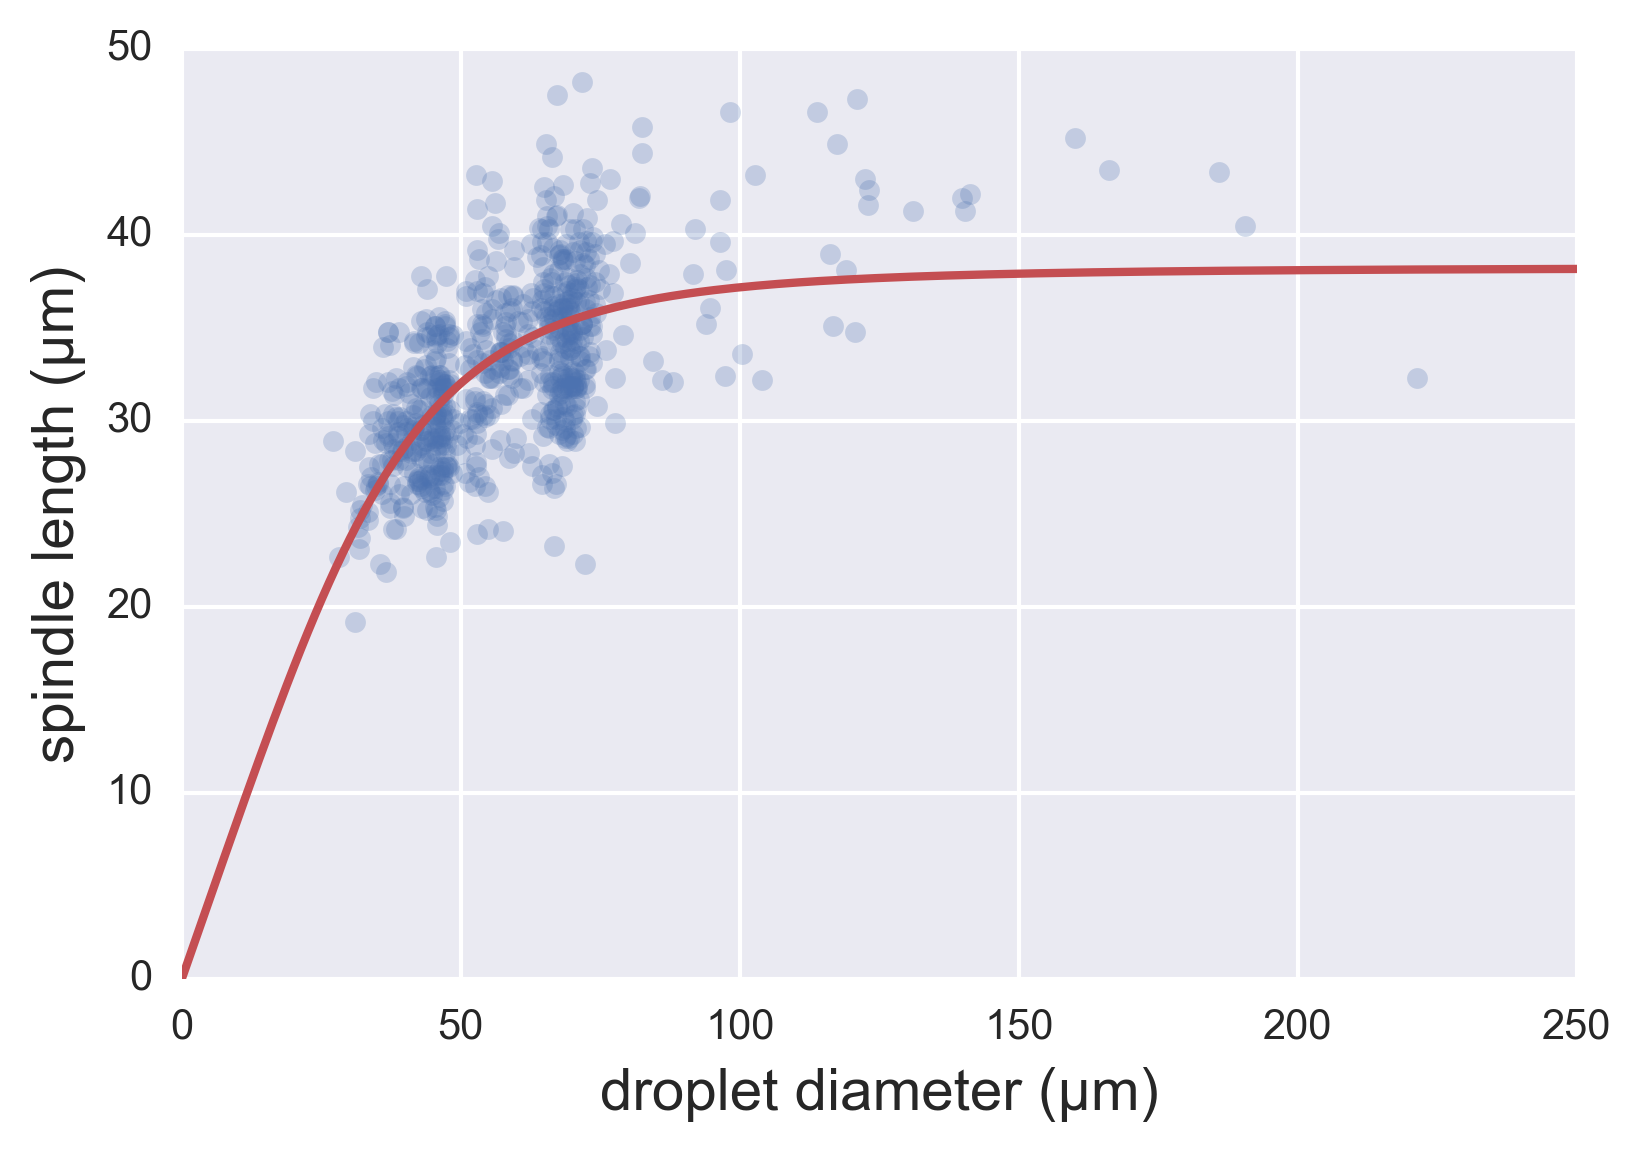

In [29]:
# Values of droplet diameter to plot
d_plot = np.linspace(0, 250, 200)

# Theoretical curve
spindle_theor = spindle_length(popt, d_plot)

# Plot results
plt.plot(df['Droplet Diameter (um)'], df['Spindle Length (um)'], marker='.', 
         linestyle='none', markersize=10, alpha=0.25)

# Plot the result
plt.plot(d_plot, spindle_theor, color=sns.color_palette()[2])
plt.xlabel('droplet diameter (µm)')
plt.ylabel('spindle length (µm)');

We see that if Model b is in fact correct, most of the droplet data lie in the nonlinear part of the curve.

### Computing the covariance matrix
To compute the covariance matrix, we need to compute the Hessian of the log of the posterior at the MAP.  We will do this numerically using the `statsmodels.tools.numdiff` module, which we imported as `smnd`. We use the function `smnd.approx_hess()` to compute the Hessian at the optimal parameter values.

In [30]:
hes = smnd.approx_hess(popt, log_post, args=args)

Now that we have the Hessian, we take its negative inverse to get the covariance matrix.

In [31]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Look at it
cov

array([[ 0.15357222, -0.00538284],
       [-0.00538284,  0.0003034 ]])

The diagonal terms give the approximate variance in the  regression parameters.  The off-diagonal terms give the covariance, which describes how the parameters relate to each other.  Nonzero covariance indicates that they are not completely independent.

We can now report our error bars with the measured covariance.

In [32]:
# Report results
print("""
Results for Model b (≈ 68% of total probability)
------------------------------------------------
θ = {0:.1f} ± {1:.1f} µm
γ = {2:.2f} ± {3:.2f}
""".format(theta, np.sqrt(cov[0,0]), gamma, np.sqrt(cov[1,1])))


Results for Model b (≈ 68% of total probability)
------------------------------------------------
θ = 38.2 ± 0.4 µm
γ = 0.86 ± 0.02



## Conclusions
You now know how to do nonlinear regression!  Formally, it is just computing the posterior probability distribution, as usual.  To summarize it, we approximated it as Gaussian and computed the MAP and covariance matrix.

It is important to note that for models with a large number of parameters, plotting the posterior distribution is intractable.  Fortunately, the summary (MAP and covariance matrix) can be computed numerically by optimization without having to plot a multidimensional posterior.  This fact, and the speed of the optimization MAP/covariance method, make it attractive.